**<h1>Group Project</h1>**

**<h1>Crime Classification in San Francisco: Predicting Crime Categories Based on Time and Location</h1>**
---

> 

   **<h2>Group members</h2>**


*   Hranush Sahradyan
*   Hasmik Margaryan
*   Ishkhanuhi Hakwbyan


>

**<h2>Purpose of the project</h2>**

This assignment focuses on building a machine learning model for crime classification in San Francisco. The dataset used for this project contains approximately 12 years of crime reports from various neighborhoods in the city. The goal is to predict the category of crime based on the given time and location information.

**<h2>Dataset Overview</h2>**

The dataset used in this project is sourced from Kaggle and provides comprehensive crime reports from 1934 to 1963. The dataset covers various neighborhoods in San Francisco, including Sunset, SOMA, Marina, and Excelsior. Each crime report entry includes information such as the date, time, and location of the crime, as well as the reported crime category. Here is the [kaggle page](https://www.kaggle.com/competitions/sf-crime/overview) of the assignment.


**<h2>Dataset Description</h2>**

This dataset contains incidents derived from SFPD Crime Incident Reporting system. The data ranges from 1/1/2003 to 5/13/2015. The training set and test set rotate every week, meaning week 1,3,5,7... belong to test set, week 2,4,6,8 belong to training set. 

**Data fields**
* **Dates** - timestamp of the crime incident
* **Category** - category of the crime incident (only in train.csv). This is the target variable you are going to predict.
* **Descript** - detailed description of the crime incident (only in train.csv)
* **DayOfWeek** - the day of the week
* **PdDistrict** - name of the Police Department District
* **Resolution** - how the crime incident was resolved (only in train.csv)
* **Address** - the approximate street address of the crime incident 
* **X** - Longitude
* **Y** - Latitude



>
>
>
>
>
>
>
>
>
>
>
>
>
>
>


**<h2>Contents</h2>**


1.   [Data Cleaning and Preprocessing](#preproc)
3.   [Feature Selection/Extraction](#fenigine)
4.   [EDA](#eda)
4.   [MODEL](#models)...
    
    
>
>
>
>
>
>
>
>
>
>
>
>
>
>
>

<a name="preproc"></a>
# Data Cleaning and Preprocessing

In [19]:
import pandas as pd
from shapely.geometry import  Point
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import urllib.request
import shutil
import zipfile
import os
import re
import contextily as ctx

In [20]:
sf_crime_data = pd.read_csv("train.csv", parse_dates=['Dates'])
sf_crime_data.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [21]:
# Percentage of Null values
with pd.option_context('display.max_rows', None,'display.max_columns', None):
    print((sf_crime_data[sf_crime_data.columns[sf_crime_data.isnull().any()]].isnull().sum() * 100 / sf_crime_data.shape[0]).sort_values(ascending=False))

Series([], dtype: float64)


In [22]:
# Defining the range for crimes
print('First date: ', str(sf_crime_data.Dates.min()))
print('Last date: ', str(sf_crime_data.Dates.max()))

First date:  2003-01-06 00:01:00
Last date:  2015-05-13 23:53:00


In [23]:
sf_crime_data.duplicated().sum()

2323

In [24]:
sf_crime_data.drop_duplicates(inplace=True)

In [25]:
sf_crime_data.shape

(875726, 9)

C:\Users\User\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\User\AppData\Local\Temp\ipykernel_6084\145112668.py:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


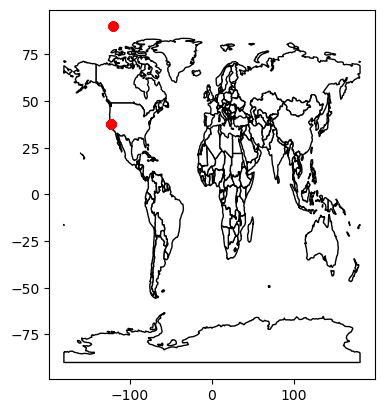

In [26]:
def create_gdf(df):
    gdf = df.copy()
    gdf['Coordinates'] = list(zip(gdf.X, gdf.Y))
    gdf.Coordinates = gdf.Coordinates.apply(Point)
    gdf = gpd.GeoDataFrame(
        gdf, geometry='Coordinates', crs={'init': 'epsg:4326'})
    return gdf

train_gdf = create_gdf(sf_crime_data)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black')
train_gdf.plot(ax=ax, color='red')
plt.show()

In [27]:
train_gdf = train_gdf.to_crs(epsg=3857)


In [28]:
print(sf_crime_data.loc[sf_crime_data.Y > 50].count())

Dates         67
Category      67
Descript      67
DayOfWeek     67
PdDistrict    67
Resolution    67
Address       67
X             67
Y             67
dtype: int64


In [29]:
sf_crime_data = sf_crime_data.drop(sf_crime_data[(sf_crime_data.Y > 50)].index)

In [30]:
sf_crime_data.shape

(875659, 9)

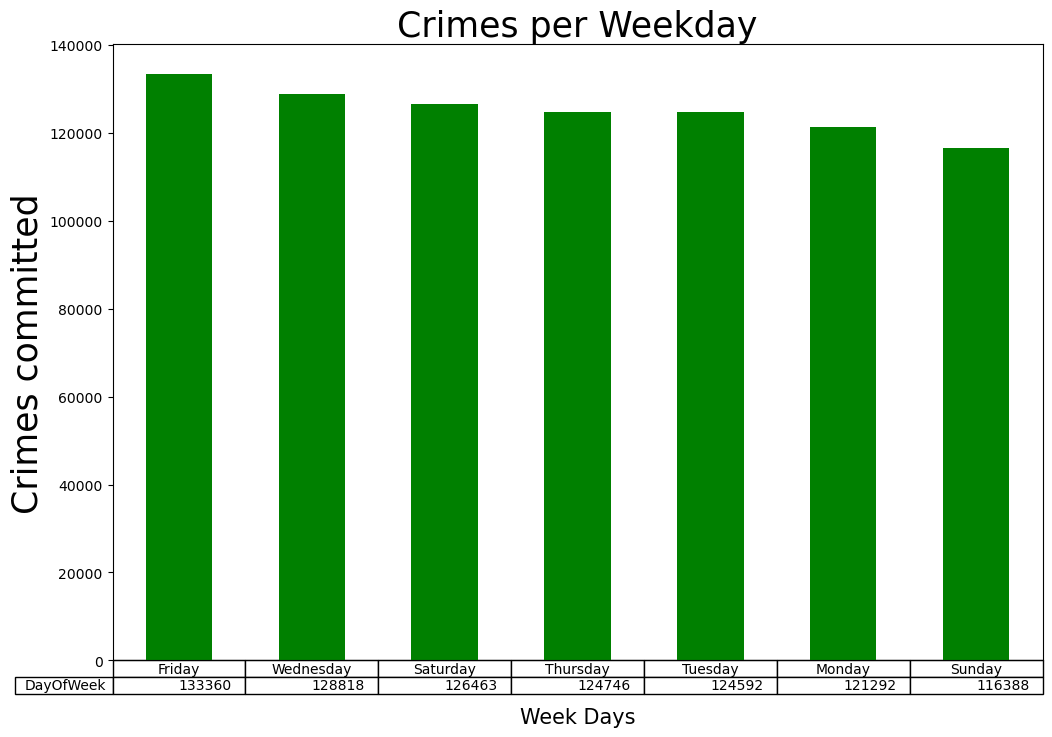

In [31]:
week = sf_crime_data['DayOfWeek'].value_counts()
week.plot(kind="bar",figsize=(12,8), table=True,  color='g')

plt.xticks([])
plt.xlabel('Week Days',fontsize=15,labelpad=30)
plt.ylabel('Crimes committed',fontsize=25)
plt.title('Crimes per Weekday',fontsize=25)
plt.show()

# week.describe()

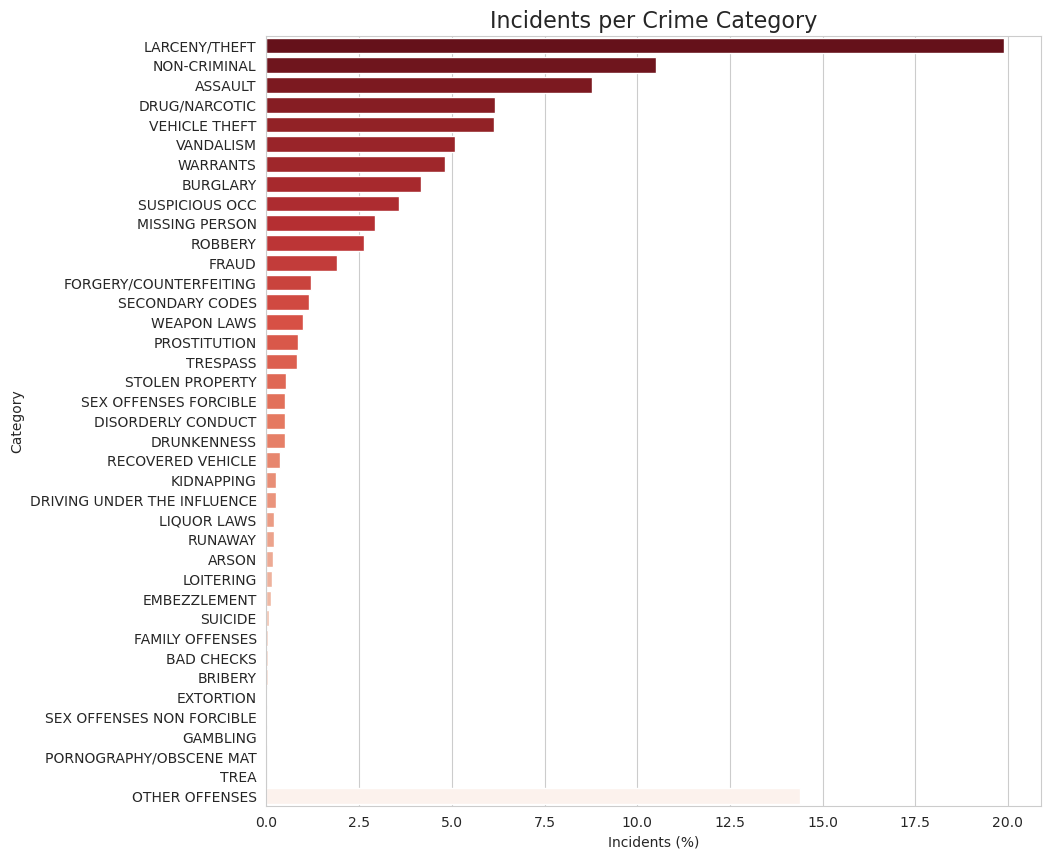

In [32]:
data = sf_crime_data.groupby('Category').count().iloc[:, 0].sort_values(ascending=False)
data = data.reindex(np.append(np.delete(data.index, 1), 'OTHER OFFENSES'))

plt.figure(figsize=(10, 10))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        x=(data.values / data.values.sum()) * 100,
        y=data.index,
        orient='h',
        palette="Reds_r")

plt.title('Incidents per Crime Category', fontdict={'fontsize': 16})
plt.xlabel('Incidents (%)')

plt.show()


/Users/ishkhanuhi/opt/anaconda3/envs/sf_crime_claassification/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/ishkhanuhi/opt/anaconda3/envs/sf_crime_claassification/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


AttributeError: module 'contextily' has no attribute 'sources'

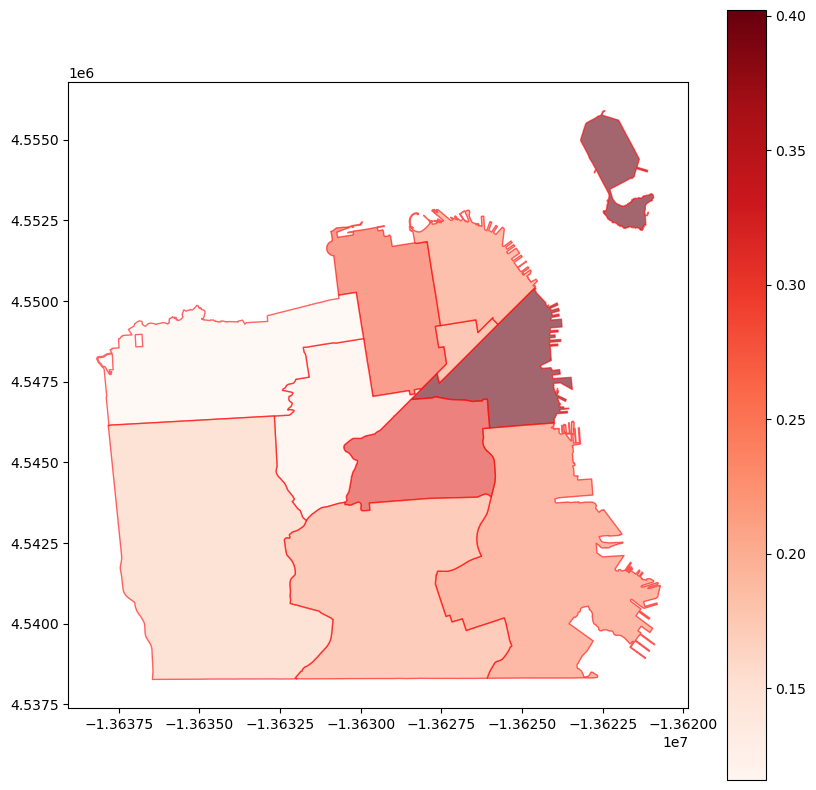

In [48]:
# Downloading the shapefile of the area
url = 'https://data.sfgov.org/api/geospatial/wkhw-cjsf?method=export&format=Shapefile'
with urllib.request.urlopen(url) as response, open('pd_data.zip', 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
# Unzipping it
with zipfile.ZipFile('pd_data.zip', 'r') as zip_ref:
    zip_ref.extractall('pd_data')
# Loading to a geopandas dataframe
for filename in os.listdir('./pd_data/'):
    if re.match(".+\.shp", filename):
        pd_districts = gpd.read_file('./pd_data/'+filename)
        break
# Defining the coordinate system to longitude/latitude
pd_districts.crs={'init': 'epsg:4326'}

# Merging our train dataset with the geo-dataframe
pd_districts = pd_districts.merge(
    train_gdf.groupby('PdDistrict').count().iloc[:, [0]].rename(
        columns={'Dates': 'Incidents'}),
    how='inner',
    left_on='district',
    right_index=True,
    suffixes=('_x', '_y'))

# Transforming the coordinate system to Spherical Mercator for
# compatibility with the tiling background
pd_districts = pd_districts.to_crs({'init': 'epsg:3857'})

# Calculating the incidents per day for every district
train_days = train_gdf.groupby('Dates').count().shape[0]
pd_districts['inc_per_day'] = pd_districts.Incidents/train_days

# Ploting the data
fig, ax = plt.subplots(figsize=(10, 10))
pd_districts.plot(
    column='inc_per_day',
    cmap='Reds',
    alpha=0.6,
    edgecolor='r',
    linestyle='-',
    linewidth=1,
    legend=True,
    ax=ax)

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    """Function that add the tile background to the map"""
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

# Adding the background
add_basemap(ax, zoom=11, url=ctx.sources.ST_TONER_LITE)

# Adding the name of the districts
for index in pd_districts.index:
    plt.annotate(
        pd_districts.loc[index].district,
        (pd_districts.loc[index].geometry.centroid.x,
         pd_districts.loc[index].geometry.centroid.y),
        color='#353535',
        fontsize='large',
        fontweight='heavy',
        horizontalalignment='center'
    )

ax.set_axis_off()
plt.show()


<a name="fenigine"></a>
# Feature Selection/Extraction